In [1]:
from QHD import *

import matplotlib.pyplot as plt
import numpy as np

# The Morse Potential

For this first module, we will be looking at a morse potential.

### 1. The Potential

We first must define the potential along with its parameters, as described below for the O-H stretch in a water molecule.

**Parameters**

$D = 4.419 eV$

$\alpha = 2.567 A^{(-1)}$

$q_0 = 0 A$




**Potential**

$V(q) = D*(1-e^{-\alpha(q-q_0)})^2$

We can define this potential as `potential`, and define the given parameters as `D`, `alpha`, and `q_0` as described below. We will also need to define the dependent variable, in this case `q` as a range using the `linspace` function found in `numpy`. The parameters are all in *atomic units*.

In [2]:
D = 4.419 *0.0367493 # eV -> Hartree
D1 = 1 *0.0367493 # eV -> Hartree
alpha = 2.567 # Angstrom(-1) 
q_0 = 0 # Angstrom
q = np.linspace(-10, 10, 1000) # Angstrom

potential = D * (1 - np.exp(-alpha*(q-q_0)))**2
potential1 = D1 * (1 - np.exp(-alpha*(q-q_0)))**2

# Above values given in QHD paper for water O-H stretch

Now that the parameters and potential have been defined, the potential can be plotted using the `matplotlib.pyplot` library. Any of the lines can be changed as desired.

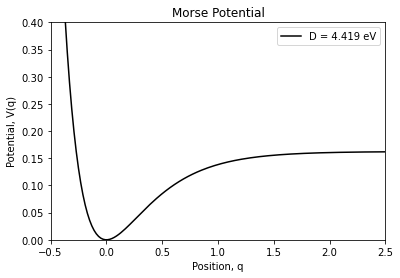

In [3]:
plt.plot(q, potential, 'k')
#plt.plot(q, potential1, 'm')
plt.legend(["D = 4.419 eV", "D = 1 eV"])
plt.title("Morse Potential") # Title of the graph
plt.ylim(0, 0.4) # (Lower, Upper) limit of the y-axis
plt.ylabel("Potential, V(q)") 
plt.xlim(-0.5, 2.5) # (Lower, Upper) limit of the x-axis
plt.xlabel("Position, q")
plt.savefig('morse_vVq.png') # Save to this file name, as a png file
plt.show()

### 2. Derivation of  QHD formulas

Here, we use the pysces library, able to derive the equations of motion in the QHD method. We will need to define the `q`, `p`, `p2`, `x`, `x2`, and `xp` variables. In order to do this, we must first calculate the first and second derivatives of the potential of interest, defined in section 1. We will also use a change of variables as well, described below.

**2.1 The First and Second Derivatives of the Potential**

To take the derivatives, we must represent the potential symbolically. This can be done by:

In [4]:
# First, we must define all the parameters as stated in section 1 as symbols:

D, alpha, q_0, q = symbols("D, alpha, q_0, q")

# When computing symbolically, we do not need to use the numpy exponential function.

potential_sym = D * (1 - exp(-alpha*(q-q_0)))**2

Now that the potential is represented symbolically, we may take the first and second derivatives, described by diff1 and diff2, respectively

In [5]:
diff1 = diff(potential_sym, q)
diff2 = diff(diff1, q)

diff1, diff2

**2.2 Change of Variable**

We can do a change of variable in the potential to:

$$x=e^{-\alpha q}$$

And so:

$$V(q)=D[x^2-2x]$$

We will now take the first and second derivatives of the original potential, and then perform the change of variables.

- The First Derivative:

In [6]:
x = Symbol("x")

diff11 = diff1.replace(exp(-alpha*(q-q_0)), x).replace(exp(-2*alpha*(q-q_0)), x**2)

diff11

- The Second Derivative:

In [7]:
diff22 = diff2.replace(exp(-alpha*(q-q_0)), x).replace(exp(-2*alpha*(q-q_0)), x**2)

diff22

We can now solve for the equations of motion.

**2.3 Solving for the Equations of Motion**

We must solve the equations of motion for `q`, `p`, `x`, `x2`, and `xp` using the parameters defined in section 1.

In [8]:
# Again, we must first define all variables as symbols. #

q, p, x, x2, xp, dt, mass, alpha, D = symbols("q, p, x, x2, xp, dt, mass, alpha, D")



########## EOM Calculations ##########

# If you want to see the output of any of the below, uncomment the desired print line. #

q1 = str(QHD_int(q, 1, dt))

#print("q = " + str(q1))

x1 = str(QHD_int(x, 1, dt))

#print("x = " + str(x1))

x21 = str(QHD_int(x, 2, dt))

#print("x2 = " + str(x21))

xp1 = str(QHD_int(xp, 1, dt))

#print("xp = " + str(xp1))

p1 = str(sympify(str(QHD_int(p, 1, dt)).replace("Derivative(v(q), q)", str(diff11))))

#print("p = " + str(p1))

p21 = str(sympify(str(QHD_int(p, 2, dt)).replace("Derivative(v(q), (q, 2))", str(diff22)).replace("Derivative(v(q), q)", str(diff11))))

#print("p2 = " + str(p21))

Now, we are ready to make plots of the data based on the EOM's as computed above.

# 3. Graphing

**3.1 Generating Time-Dependent Values**

We will first define all of the parameters necessary to perform the QHD calculations.

In [9]:
### Specific Parameters: ###

D = 4.419 * 0.0367493
#D = 1 * 0.0367493
mass = 1836
alpha = 2.56


### Constants: ###




### General Parameters: ###

# The general parameters can be left as-is (if desired) unless otherwise stated. #

q0 = 0.15
p0 = 0.0
s0 = 0.05
ps0 = 0.0

Etot = 0.0
Etot0 = 0.0
Etot_cl = 0.0
Etot_cl0 = 0.0
q,p,p2,x,x2,xp = 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
q, p = q0, p0
p2 = p*p + ps0*ps0 + (0.5*hbar/s0)**2

# If you are using a potential other than the morse potential, please change: #

x = exp(-alpha*q0)*exp(0.5*alpha*alpha*s0*s0)
x2 = exp(-2.0*alpha*q0)*exp(2.0*alpha*alpha*s0*s0)
xp = x*(p - s0*ps0*alpha)

Etot, Etot_cl = Etot0, Etot_cl0


### Initial Conditions for Energy: ###

dt = 0.0
p = QHD_int(p, 1, dt)
p2 = QHD_int(p, 2, dt)
Ekin_cl = 0.5*p*p/mass
Ekin    = 0.5*p2/mass

# If you are using a different potential, please change the below potentials: #

Epot_cl = D*(math.exp(-2.0*alpha*q) - 2.0*math.exp(-alpha*q))
Epot    = D*(x2 - 2.0*x)
Etot_cl = Ekin_cl + Epot_cl
Etot    = Ekin    + Epot

Etot, Etot_cl = Etot0,Etot_cl0


### Empty Lists for Data Storage: ###

q_list = [] 
e_list0 = [] 
e_list1 = [] 
e_list2 = [] 

Now that the parameters have been defined, we can compute the desired values of position and energy over a given time interval.

In [11]:
### Time how long it takes to compute ###

import time 
begin = time.time()

### Compute the x values ###

dt = 0.1 # step size
t_i = 0.0 # start
t_f = 1000 # finish

### Compute the y values ###

while t_i <= t_f:

    xp = eval((xp1))
    
    x2 = eval((x21))
    
    x = eval((x1))
   
    q = eval((q1))  
    
    p = eval((p1))
    
    p2 = eval((p21))
    
    Ekin_cl = 0.5*p**2/mass
    Ekin    = 0.5*p2/mass
    Epot_cl = D*(exp(-2.0*alpha*q) - 2.0*exp(-alpha*q))
    Epot    = D*(x2 - 2.0*x)
    Etot_cl = Ekin_cl + Epot_cl
    Etot    = Ekin    + Epot

#    Etot = Etot0
    
#    Etot1 = Etot/Etot0
    
#    e_list0.append(Etot1)

    e_list1.append(Etot)
    e_list2.append(Etot_cl)
    
    q_list.append(q)
    
    t_i = t_i + dt
    
time.sleep(1)
# store end time
end = time.time()
  
# total time taken
print(f"Total runtime is {end - begin}")

Total runtime is 44.35532331466675


The above cell takes about 40-45 seconds to run.

In [12]:
# Issue with E/E_0

For the x values, we create a range with `(t_i, t_f, dt)` as the parameters. Due to the increasing nature of `t_i`, the initial value of `0.0` is used in its place.

In [14]:
### Define the x values ###

x_list = np.arange(0, t_f, dt)

**3.2 Graphing Position versus Time**

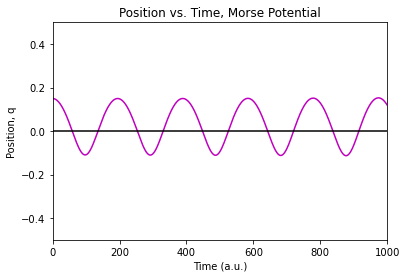

In [15]:
plt.plot(x_list, q_list, 'm')
plt.plot([0, 1000], [0, 0], "k")
plt.title("Position vs. Time, Morse Potential")
plt.xlim(0, 1000)
plt.xlabel("Time (a.u.)")
plt.ylim(-0.5, 0.5)
plt.ylabel("Position, q")
plt.savefig('morse_qVt.png')
plt.show()

**3.3 Energy versus Time**

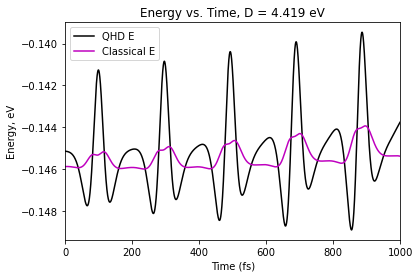

In [16]:
#plt.plot(x_list, e_list)
plt.plot(x_list, e_list1, "k")
plt.plot(x_list, e_list2, "m")
plt.legend(["QHD E", "Classical E"])
#plt.plot([0, 500], [0, 0], "k-")
plt.title("Energy vs. Time, D = 4.419 eV")
plt.xlim(0, 1000)
plt.xlabel("Time (fs)")
#plt.ylim(-5, 0.5)
plt.ylabel("Energy, eV")
plt.savefig('morse_eVt.png')
plt.show()